# Final Explainer Notebook

This notebook is done as part of the final project for 02806 Social Data Analysis and Visualization, Technical University of Denmark.

This notebook contains all the code used for the website: https://restaurant-guide.github.io/

Please note that this notebook is only rendered with data from 2019-2021, so not the full dataset. This is done, because of GitHub storage limitations. 

## 1. Motivation
### 1.1 Purpose 

The aim of the final project for Social Data Analysis and Visualization is to investigate restaurants and their reviews through a dataset from Yelp. The company Yelp will be described in the next subsection. Nowadays before going to a restaurant, you look it up on Google. Here it is possible to check the ratings of a restaurant and the comments. Hence, fake reviews are a hot topic, where business owners can promote their business falsely. The idea of this project is to find the best restaurant based on chosen types of restaurant, kitchen, price, review score without fake reviews in the dataset. From this, the user is able to find the perfect restaurant through an interactive application, but also see how the fake reviews are detected.




<!-- The aim of the project is to find the best restaurant based on chosen type of restaurant, kitchen, price, review score without fake reviews.  -->


### 1.2 Data
The dataset considered for this project is from Yelp, which is an American company founded in 2004. The idea behind the company is to publish crow-sourced reviews about businesses through their website Yelp.com and mobile app Yelp. In the second quarter of 2019, Yelp has an average of 61.8 million unique visitors through their website, while it was 76.7 million unique visitors in the app. As the internet gets filled with more and more information and the likelihood of the information being false, Yelp can then provides a local platform for people to discover true information. So the dataset from Yelp considers different businesses and not only restaurants, which is the focus of this project. If a restaurant is not part of Yelp, they are not considered in this project. 

Overall, the Yelp dataset is a subset of Yelp's businesses, reviews and users, which covers 11 metropolitan areas. All the dataset consists of the following information:
* 8,635,403 reviews
* 160,585 business
* 200,000 pictures
* 2,189,457 unique users

The dataset stretches over a period from 14th of October 2004 to 28th of January 2021. 

For this project, three of Yelps dataset is used. The main dataset consists of all the different businesses and some attributes explaining opening hours, price range and category. Furthermore, a dataset consisting of all the reviews and when the reviews are given is also used. To detect anomalies in the data, the dataset about the user that has given a review is also used. So to sum up, the following data files were used throughout this project
* yelp_academic_dataset_business.json (121.466 KB)
* yelp_academic_dataset_review.json (6.774.100 KB)
* yelp_academic_dataset_user.json (3.598.150 KB)

See reference [1] for the data. 

## 2. Basic stats. Let's understand the dataset better

Before doing data analysis on the dataset, it is key to do some basic statistics on the chosen dataset. Before doing basic statistics, some data cleaning and preprocessing are done.

### 2.1 Data cleaning & preprocessing

As mentioned in the section about the dataset, there are multiple businesses considered in our dataset. The businesses that do not have the word *Restaurant* in the column `categories` will not be considered. Further, restaurants that are closed have been removed, because it does not make sense to give advice for the user to go to a closed restaurant. 
To get some useful information from the `categories` column, two new variables are created. The first variable explains the kitchen type of the restaurant, whereas the second variable explains the type of restaurant, i.e. if it is a pizzeria. The list of words for the two variables are presented below

* Kitchen type: Thai, Chinese, Japanese, Korean, Indian, American, Caribean, Italian, Mediterranean, Mexican, Cajun, Vietnamese and Greek.
* Type: Food, nightlife, bars, sandwiches, pizza, breakfast & brunch, fast food, burgers, salad, buffet, cafes, coffee & tea, vegetarian, steakhouse, sushi bars, diners and wine bars. 

The data from Yelp also give what state the different restaurants are in but in abbrivations. Hence the full state name and to do some plotting later on where the states are, the states latitude and longitude are also inserted. 

From merging the three datasets, the shape is `(6.588.460, 27)`, to make with more compatible a shorter time period is considered, namely 1st of January 2014 to 28th of January 2021, which gives a shape of `(5.177.322, 27)`. Remeber that these numbers cannot be compared with the shapes below, since this notebook only covers around two years.

To see the dataprep alone, please see the python file: `Social Data - Data Prep - Final`

#### Libaries
The libraries used for this project are presented below.

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import os

# plot functions
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, curdoc, output_file
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, GeoJSONDataSource, \
                        LinearColorMapper, ColorBar, NumeralTickFormatter, Div, Select, TableColumn, \
                        DataTable, CheckboxGroup, Tabs, Panel, CheckboxButtonGroup, RadioButtonGroup
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.palettes import Category20c, Pastel1, Set3, Blues
from bokeh.layouts import column, row, WidgetBox, gridplot
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.tile_providers import get_provider, Vendors
from bokeh.transform import linear_cmap,factor_cmap
output_notebook()

#Anomaly detection

import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install python-Levenshtein

from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from collections import Counter
from sklearn.ensemble import IsolationForest

from wordcloud import WordCloud
import matplotlib.pyplot as plt

Loading BokehJS ...

### 2.1.1. Preprocessing of data

In [2]:
#path = 'C:\\Users\\Miche\\OneDrive - Danmarks Tekniske Universitet\\MMC\\2. Semester\\Social Data\\websites\\data'
path = '/Users/Ellen/Documents/Dokumenter/DTU/6.Semester/SocialData/Project/yelp_dataset'
os.chdir(path)
os.getcwd()

'/Users/Ellen/Documents/Dokumenter/DTU/6.Semester/SocialData/Project/yelp_dataset'

In [3]:
df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
print(df.shape)

(160585, 14)


Checking which columns we have available. 

In [4]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

We only want to look at the restaurants that are open and not closed.

In [5]:
df = df[df['is_open']==1]
df = df.drop(['is_open'], axis=1)

Start by select all the rows that mention restaurants.

In [6]:
df = df[df['categories'].str.contains('Restaurants',
              case=False, na=False)]

df_explode = df.assign(categories = df.categories
                         .str.split(', ')).explode('categories')

df_explode.categories.value_counts().head(20)

Restaurants                  32022
Food                         10732
Nightlife                     5550
Bars                          5345
Sandwiches                    4795
American (Traditional)        4379
Fast Food                     4326
Pizza                         3890
Breakfast & Brunch            3872
American (New)                3254
Burgers                       3246
Coffee & Tea                  3010
Mexican                       2815
Chinese                       2329
Italian                       2130
Seafood                       1998
Salad                         1975
Event Planning & Services     1916
Cafes                         1871
Japanese                      1773
Name: categories, dtype: int64

In [7]:
remove = ['Food Delivery Services','Food Safety Training', 'Food Tours', 
          'Food Banks','Chinese Martial Arts','Traditional Chinese Medicine',
         'Coffee & Tea Supplies','Japanese Curry', 'Food Court',
         'Food Trucks','Food Stands']

df = df[~df['categories'].str.contains('|'.join(remove),
              case=False, na=False)]

Try to split the category column into different subgroups, so we can do some nice plotting.

In [8]:
cat_kitchens = ['thai', 'chinese','japanese','korean','indian','american',
                 'caribbean','italian','mediterranean','mexican', 'cajun',
                'vietnamese','greek']

cat_type = ['Food','Nightlife','Bars','Sandwiches','Pizza','Breakfast & Brunch', 'Fast Food',
            'Burgers','Salad', 'Buffet', 'Cafes','Coffee & Tea', 'Vegetarian', 'Steakhouse', 'Sushi Bars',
            'Diners','Wine Bars']

df_explode = df.assign(categories = df.categories
                         .str.split(', ')).explode('categories')


df_cat_kitchen = df_explode[df_explode['categories'].str.contains(
              '|'.join(cat_kitchens),
              case=False, na=False)]

df_cat_kitchen = df_cat_kitchen.rename(columns={'categories':'cat_kitchen'})
df_cat_kitchen = df_cat_kitchen['cat_kitchen']

df_cat_type = df_explode[df_explode['categories'].str.match(
              '|'.join(cat_type),
              case=True, na=False)]

df_cat_type = df_cat_type.rename(columns={'categories':'cat_type'})
df_cat_type = df_cat_type['cat_type']

In [9]:
df_cat_kitchen.unique()

array(['American (Traditional)', 'Thai', 'American (New)', 'Italian',
       'Indian', 'Mexican', 'Chinese', 'Caribbean', 'Japanese',
       'Mediterranean', 'Greek', 'Vietnamese', 'Latin American',
       'Cajun/Creole', 'Korean', 'New Mexican Cuisine'], dtype=object)

In [10]:
df_cat_type.unique()

array(['Food', 'Bars', 'Nightlife', 'Salad', 'Sandwiches', 'Cafes',
       'Vegetarian', 'Breakfast & Brunch', 'Pizza', 'Sushi Bars',
       'Steakhouses', 'Fast Food', 'Burgers', 'Coffee & Tea', 'Diners',
       'Buffets', 'Wine Bars'], dtype=object)

In [11]:
df_merge_list = [df, df_cat_kitchen, df_cat_type]

df_merged = reduce(lambda  left, right: pd.merge(left,right,left_index=True,
                                            right_index=True), df_merge_list)

df_merged.shape

df_merged.state.unique()

array(['CO', 'FL', 'MA', 'OR', 'OH', 'GA', 'TX', 'BC', 'WA', 'KS', 'KY'],
      dtype=object)

Below is a for-loop and if-statement, this is used to insert the full name of the state. It is assumed that not all people know what state MA is. Furthermore, the latitude and longitude for each state is also inserted. These are used later to give us an overview over where we have data from.

In [12]:
name = []
long = []
lat = []
for state in df_merged['state']:
    if state =='MA':
        name.append('Massachusetts')
        lat.append(42.407211)
        long.append(- 71.382439)
    elif state =='FL':
        name.append('Florida')
        lat.append(27.994402)
        long.append(-81.760254)
    elif state =='OR':
        name.append('Oregon')
        lat.append(44.000000)
        long.append(-120.500000)
    elif state =='BC':
        name.append('British Columbia')
        lat.append(53.726669)
        long.append(-127.647621)
    elif state =='GA':
        name.append('Georgia')
        lat.append(33.247875)
        long.append(-83.441162)
    elif state =='TX':
        name.append('Texas')
        lat.append(31.000000)
        long.append(-100.000000)
    elif state =='OH':
        name.append('Ohio')
        lat.append(40.367474)
        long.append(-82.996216)
    elif state =='CO':
        name.append('Colorado')
        lat.append(39.113014)
        long.append(-105.358887)
    elif state =='WA':
        name.append('Washington')
        lat.append(47.751076)
        long.append(-120.740135)
    elif state =='KS':
        name.append('Kansas')
        lat.append(38.500000)
        long.append(-98.000000)
    elif state == 'KY':
        name.append('Kentucky')
        lat.append(37.839333)
        long.append(-84.270020)
        
df_merged['state_name'], df_merged['latitude_state'], df_merged['longitude_state']  = name, lat, long

Extracting some more features, e.g. pricerange on the restaurants.

In [13]:
df_merged['attributes'] = df_merged['attributes'].apply(lambda x: {} if x is None else x)
df_att = pd.json_normalize(df_merged.attributes)
df_att = df_att['RestaurantsPriceRange2'].to_frame()

PriceRange = []
AvgPrice = []
for row in df_att['RestaurantsPriceRange2']:
    if row == '1' :    
        PriceRange.append('$')
        AvgPrice.append(1)
    elif row == '2':   
        PriceRange.append('$$')
        AvgPrice.append(20)
    elif row == '3':  
        PriceRange.append('$$$')
        AvgPrice.append(45)
    elif row == '4':  
        PriceRange.append('$$$$')
        AvgPrice.append(75)
    else:           
        PriceRange.append('Unknown')
        AvgPrice.append(0)
        
df_merged['PriceRange'], df_merged['AvgPrice'] = PriceRange, AvgPrice
df_merged.shape

df_merged['PriceRange'].value_counts()

$$         17575
$           8268
Unknown     2625
$$$         1223
$$$$         145
Name: PriceRange, dtype: int64

### 2.1.2. Load Massive dataset

**Review dataset**

In [14]:
size = 500000
review = pd.read_json('yelp_academic_dataset_review.json', lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

In [15]:
# There are multiple chunks to be read
chunk_list = []
for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(df_merged, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

df.shape

416263 out of 500,000 related reviews
384085 out of 500,000 related reviews
371677 out of 500,000 related reviews
358510 out of 500,000 related reviews
349565 out of 500,000 related reviews
356785 out of 500,000 related reviews
353610 out of 500,000 related reviews
407361 out of 500,000 related reviews
371185 out of 500,000 related reviews
362734 out of 500,000 related reviews
361974 out of 500,000 related reviews
362709 out of 500,000 related reviews
388455 out of 500,000 related reviews
373812 out of 500,000 related reviews
414622 out of 500,000 related reviews
414618 out of 500,000 related reviews
433111 out of 500,000 related reviews
107384 out of 500,000 related reviews


(6588460, 24)

**User Id dataset**

In [16]:
size = 500000
review = pd.read_json('yelp_academic_dataset_user.json', lines=True,
                      dtype={'user_id':str,'name':str,
                             'review_count':int},
                      chunksize=size)

In [17]:
# There are multiple chunks to be read
chunk_list = []
for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['useful','elite','funny','cool','friends','yelping_since',
                                      'fans','compliment_more','compliment_profile','compliment_hot',
                                      'compliment_more', 'compliment_profile', 'compliment_cute',
                                      'compliment_list', 'compliment_note', 'compliment_plain',
                                      'compliment_cool', 'compliment_funny', 'compliment_writer',
                                      'compliment_photos'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'name': 'username','review_count':'user_count'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(df, chunk_review, on='user_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

df.shape

df.columns

4073724 out of 500,000 related reviews
1175245 out of 500,000 related reviews
689031 out of 500,000 related reviews
486388 out of 500,000 related reviews
164072 out of 500,000 related reviews


Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'attributes',
       'categories', 'hours', 'cat_kitchen', 'cat_type', 'state_name',
       'latitude_state', 'longitude_state', 'PriceRange', 'AvgPrice',
       'user_id', 'review_stars', 'text', 'date', 'username', 'user_count',
       'average_stars'],
      dtype='object')

### 2.1.3. Specify time period

Remember that the time period in this explainer notebook only considers data from 2019 and onwards. 

In [18]:
print (df.date.min())
print (df.date.max())

2004-10-14 02:57:52
2021-01-28 15:23:52


In [19]:
print(df.date.dtypes)
df['date'] = pd.to_datetime(df['date'])
print(df.date.dtypes)

object
datetime64[ns]


In [20]:
time_start = pd.Timestamp(2019,1,1)

#Filter the data
df = df[(df['date']>= time_start)]

In [21]:
print (df.date.min())
print (df.date.max())
print(df.shape)

2019-01-01 00:00:09
2021-01-28 15:23:52
(1427833, 27)


## 2.2 Basic Statistics

In [22]:
print('Timeperiod of the dataset')
print (df.date.min())
print (df.date.max())

Timeperiod of the dataset
2019-01-01 00:00:09
2021-01-28 15:23:52


In [23]:
df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,longitude_state,PriceRange,AvgPrice,user_id,review_stars,text,date,username,user_count,average_stars
15,7bioKzHBPPRdM7-jJQAwkg,Cafe Aion,1235 Pennsylvania Ave,Boulder,CO,80302,40.008789,-105.276503,3.5,144,...,-105.358887,$$,20,eXRC79iX60xwA1UuGRuWNg,4,Best paella I have enjoyed in a long time on a...,2019-09-16 19:26:44,Daniel,376,4.29
16,7bioKzHBPPRdM7-jJQAwkg,Cafe Aion,1235 Pennsylvania Ave,Boulder,CO,80302,40.008789,-105.276503,3.5,144,...,-105.358887,$$,20,eXRC79iX60xwA1UuGRuWNg,4,Best paella I have enjoyed in a long time on a...,2019-09-16 19:26:44,Daniel,376,4.29
17,7bioKzHBPPRdM7-jJQAwkg,Cafe Aion,1235 Pennsylvania Ave,Boulder,CO,80302,40.008789,-105.276503,3.5,144,...,-105.358887,$$,20,eXRC79iX60xwA1UuGRuWNg,4,Best paella I have enjoyed in a long time on a...,2019-09-16 19:26:44,Daniel,376,4.29


Start by checking NaN values

In [24]:
print('Any missing values:', df.isnull().sum().sum())

Any missing values: 13490


From further analysis, the missing values were in the columns: `hours`,`address` and `username`. Since these are not being used, these can be dropped.

In [25]:
df = df.drop(['hours','address', 'username'],axis=1) 
print('Any missing values:', df.isnull().sum().sum())

Any missing values: 0


Checking the top categories in different columns

In [26]:
#exploding the dataframe so the categories column is not a list type
df_duplicates = df.drop_duplicates(subset=['name','date'])
df_explode = df_duplicates.assign(categories = df_duplicates['categories'].str.split(', ')).explode('categories')

print('Top categories in the dataset')
print(df_explode['categories'].value_counts().head(10))
print('Checking that all rows have the value *Restaurant*:', df_duplicates.shape)

Top categories in the dataset
Restaurants               474516
Nightlife                 215142
Bars                      210543
American (Traditional)    151234
Food                      145887
American (New)            142120
Breakfast & Brunch        103777
Cocktail Bars              67327
Italian                    60927
Seafood                    56583
Name: categories, dtype: int64
Checking that all rows have the value *Restaurant*: (474516, 24)


Making sure that all rows have restaurants in their cateogy, which is true. 

In [27]:
print('Top categories in the dataset based on our own variables')
print(df['cat_kitchen'].value_counts().head(10))

Top categories in the dataset based on our own variables
American (New)            402680
American (Traditional)    401768
Italian                   145842
Mexican                   115041
Japanese                   92693
Mediterranean              38533
Latin American             37376
Chinese                    34799
Thai                       33531
Vietnamese                 27448
Name: cat_kitchen, dtype: int64


In [28]:
print('Top categories in the dataset based on our own variables')
print(df['cat_type'].value_counts().head(10))

Top categories in the dataset based on our own variables
Nightlife             278677
Bars                  272804
Food                  187643
Breakfast & Brunch    139675
Sandwiches             71084
Burgers                64662
Sushi Bars             57982
Pizza                  56752
Salad                  50463
Wine Bars              40405
Name: cat_type, dtype: int64


In [29]:
print('Count of the different price ranges')
print(df['PriceRange'].value_counts())

Count of the different price ranges
$$         1067612
$           180525
$$$          98665
Unknown      72023
$$$$          9008
Name: PriceRange, dtype: int64


Some descriptive statisics for the different variables

In [30]:
variables = ['name','city','state','cat_kitchen','cat_type','PriceRange']
df[variables].describe()

,name,city,state,cat_kitchen,cat_type,PriceRange
count,1427833,1427833,1427833,1427833,1427833,1427833
unique,8552,302,11,16,17,5
top,Café Tu Tu Tango,Austin,FL,American (New),Nightlife,$$
freq,14940,206986,314503,402680,278677,1067612


So there are 11 unique states in the dataset and 302 unique cities.

In [31]:
variables = ['stars', 'AvgPrice']
round(df[variables].describe(),2)

,stars,AvgPrice
count,1427833.00,1427833.00
mean,3.85,18.66
std,0.58,11.24
min,1.00,0.00
25%,3.50,20.00
50%,4.00,20.00
75%,4.00,20.00
max,5.00,75.00


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


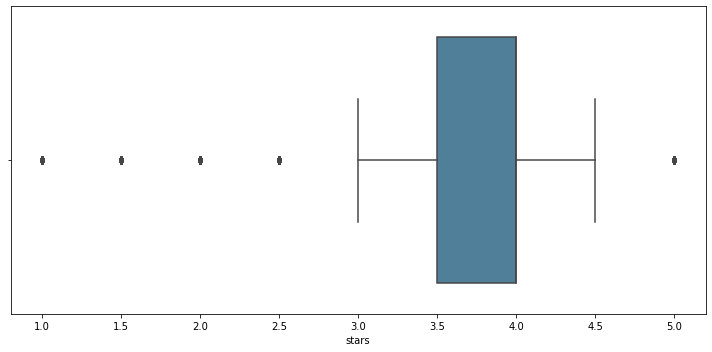

In [32]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(df['stars'], color='#2b8cbe', saturation=0.5)
plt.tight_layout(h_pad=2)

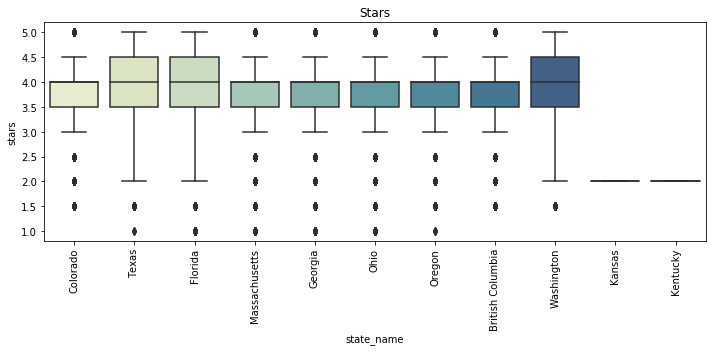

In [33]:
fig = plt.figure(figsize=(10,5))
selected = ['stars']
plt.title('Stars')
sns.boxplot(x='state_name', y='stars', data=df, palette='YlGnBu', saturation=0.5)
plt.xticks(rotation=90)
plt.tight_layout(h_pad=2)

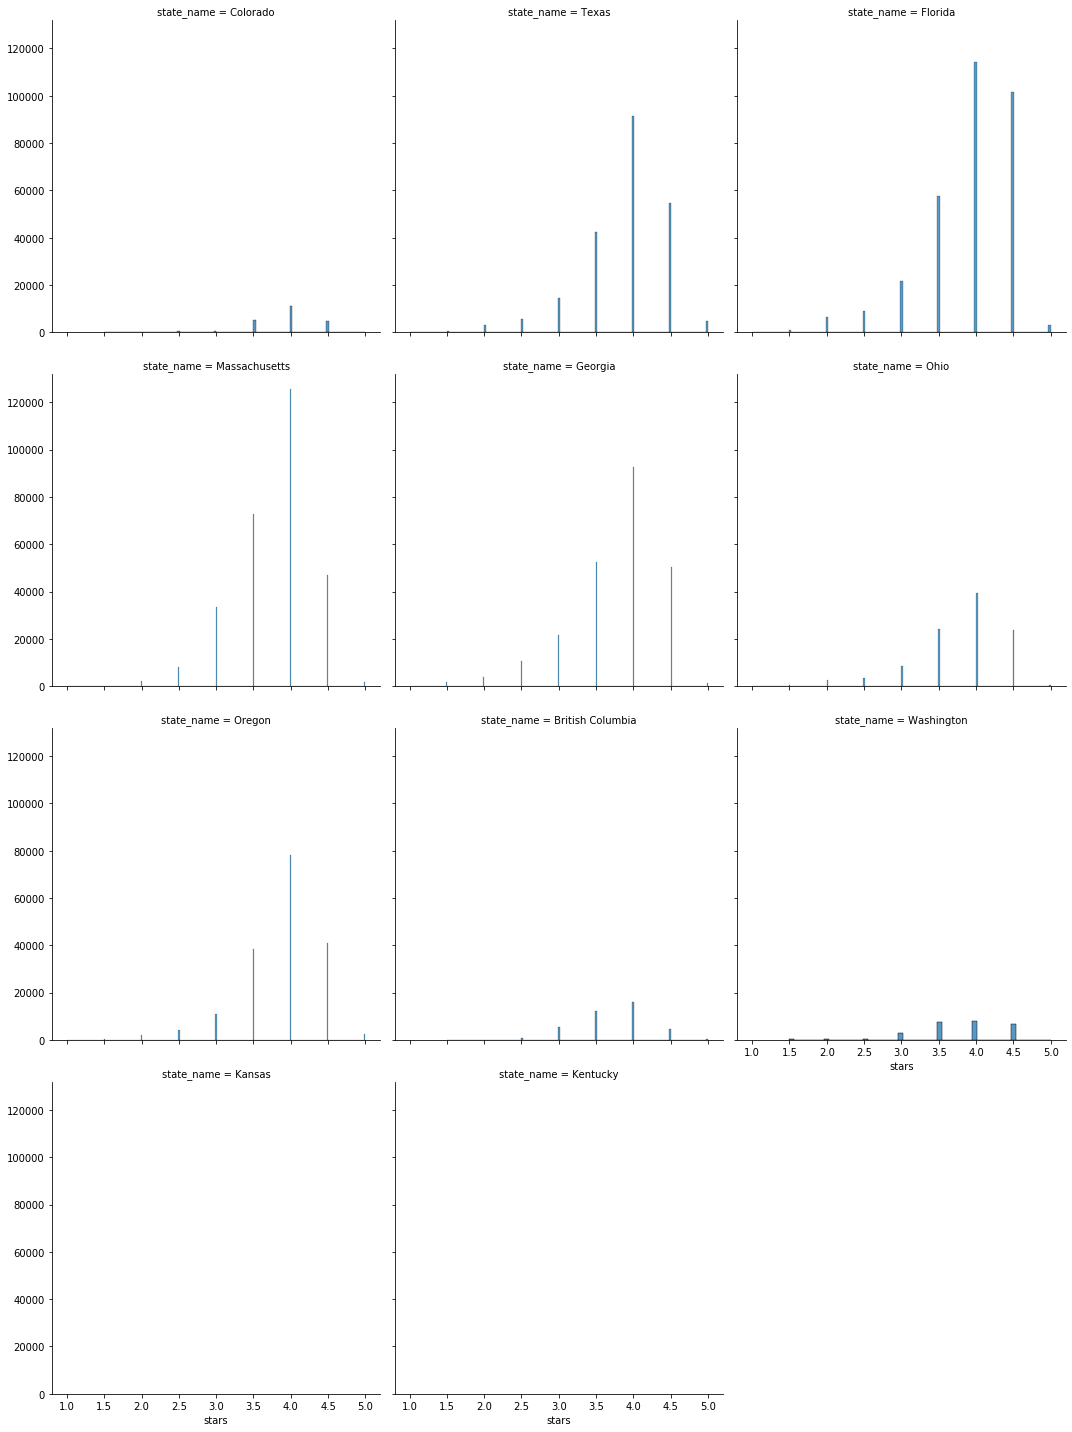

In [34]:
g = sns.FacetGrid(df, col="state_name", height=5, col_wrap=3)
g.map(sns.histplot, "stars")

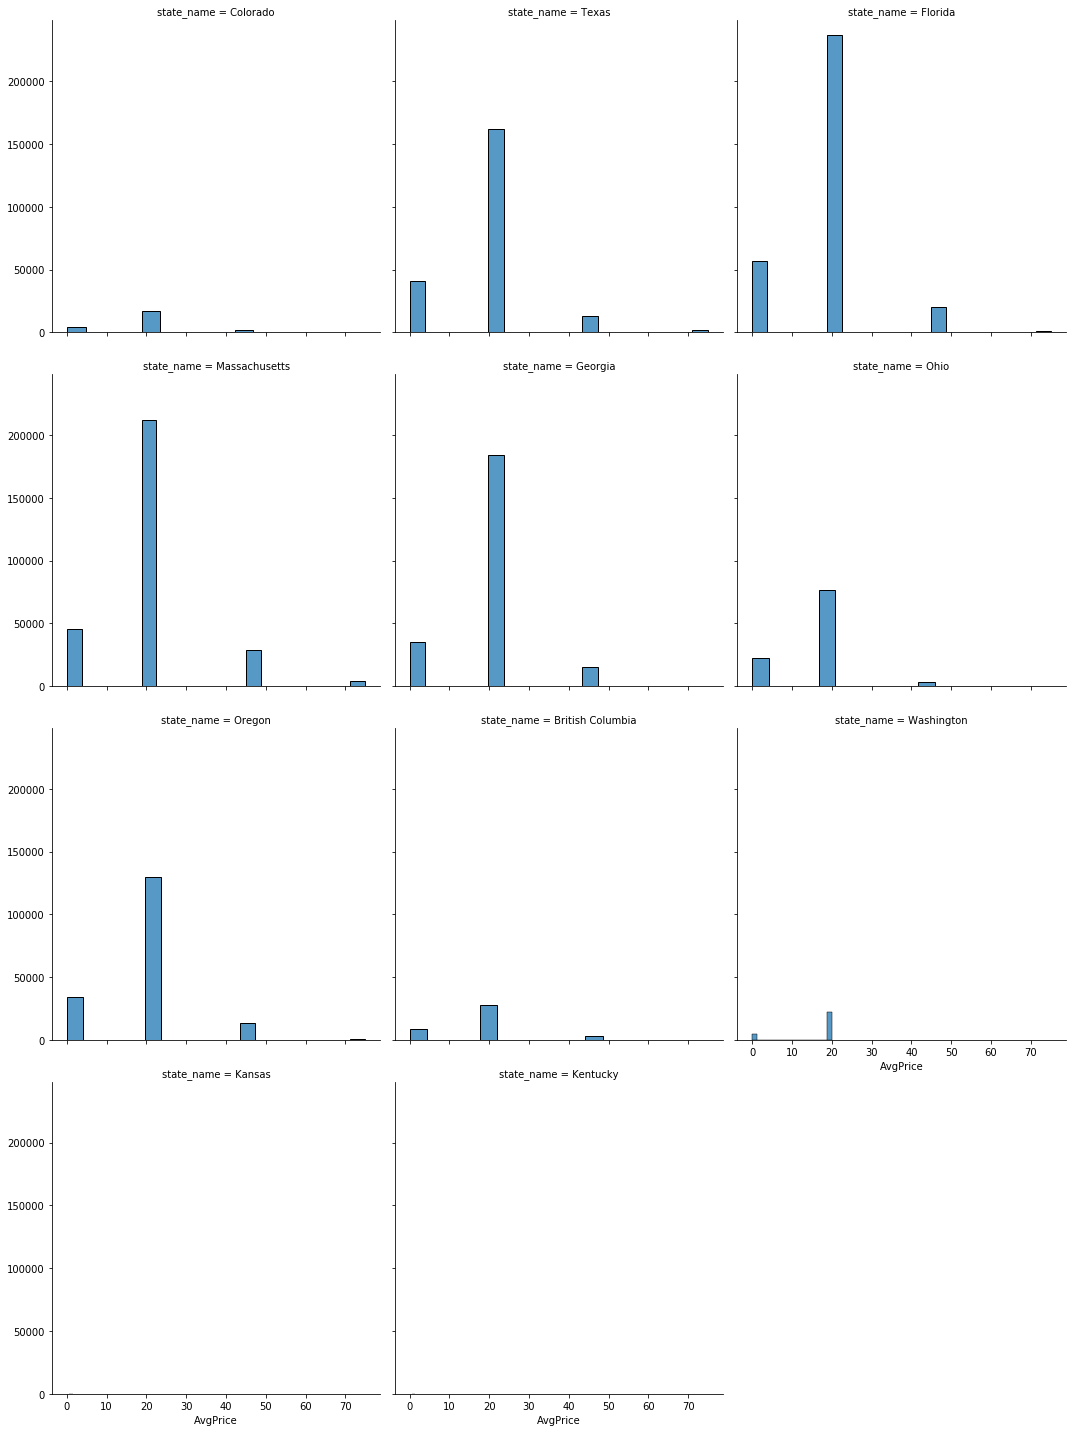

In [35]:
g = sns.FacetGrid(df, col="state_name", height=5, col_wrap=3)
g.map(sns.histplot, "AvgPrice")

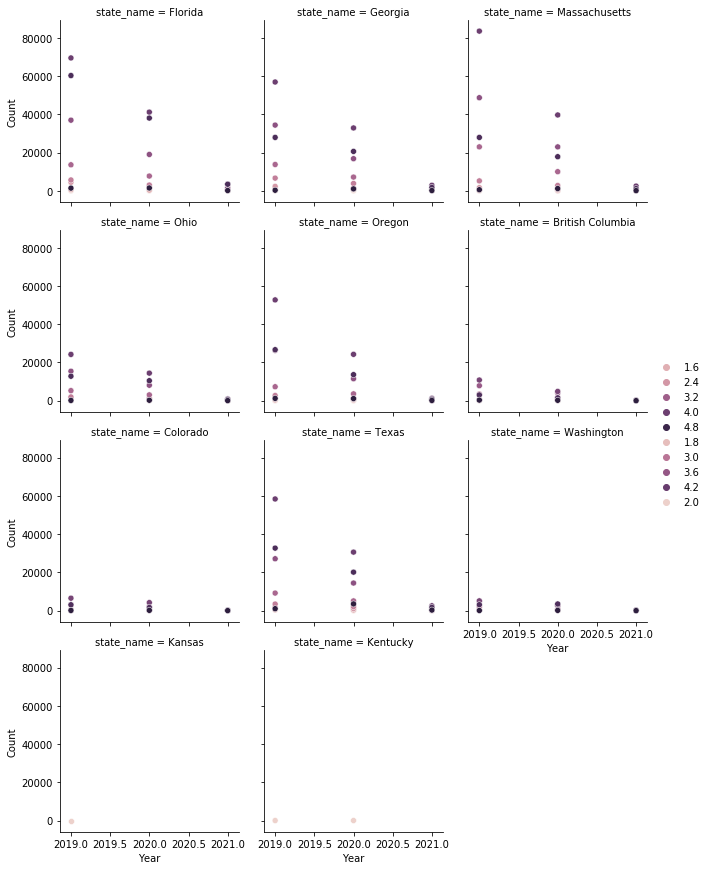

In [36]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

year_stars = df.groupby(['year','stars','state_name'])\
            .agg({'business_id':'count'}).rename({'business_id' : 'count'},axis=1)\
                    .reset_index()
year_stars.head()

g = sns.FacetGrid(year_stars, col="state_name",col_wrap=3)
g.map_dataframe(sns.scatterplot, x="year", y="count", hue='stars')
g.set_axis_labels("Year", "Count")
g.add_legend()

In [37]:
PriceRange = []
for row in df['AvgPrice']:
    if row ==  1 :    
        PriceRange.append('\$')
    elif row == 20:   
        PriceRange.append('\$\$')
    elif row == 45:  
        PriceRange.append('\$\$\$')
    elif row == 75:  
        PriceRange.append('\$\$\$\$')
    else:           
        PriceRange.append('Unknown')
        
df['price_range'] = PriceRange

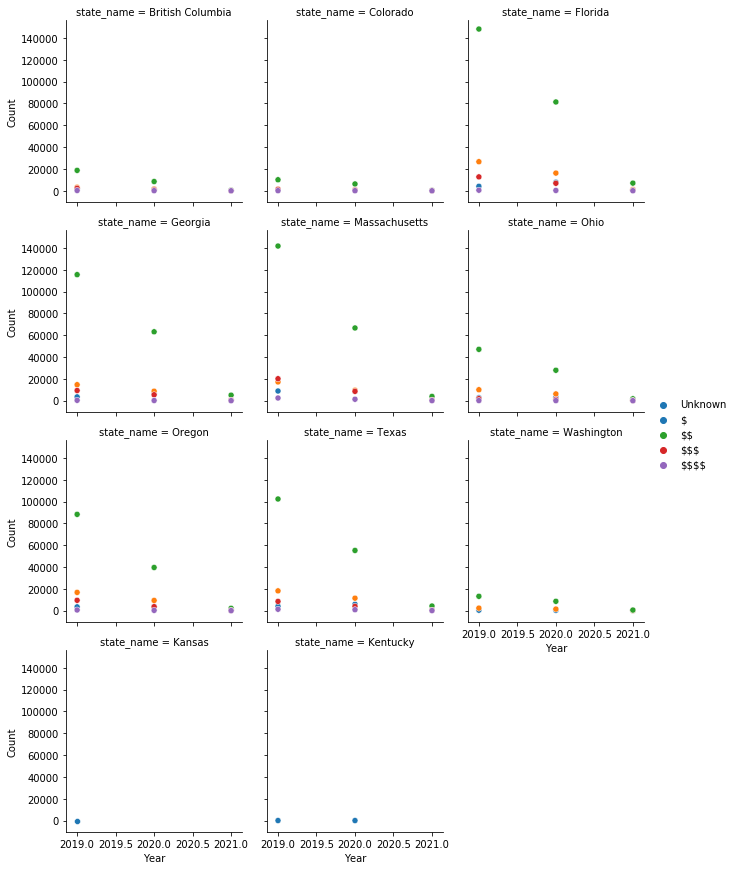

In [38]:
year_stars = df.groupby(['year','price_range','state_name'])\
            .agg({'business_id':'count'}).rename({'business_id' : 'count'},axis=1)\
                    .reset_index()

year_stars.head()


g = sns.FacetGrid(year_stars, col="state_name",col_wrap=3)
g.map_dataframe(sns.scatterplot, x="year", y="count", hue='price_range')
g.set_axis_labels("Year", "Count")
g.add_legend()

## 3. Exploratory Data Analysis

Before you get into the root cause analysis of this project, an exploratory data analysis is presented, which will give you an overview of different metrics used. The first section will give you a brief introduction to where the states, how many restaurants, but also present how many there are under the two self-made categories, namely kitchen and type. The next section will give an overview of how the stars are distributed on state, kitchen and type. The last section will dig deeper into the time-based metric. Here it will be presented what time of the day most reviews are done based on the three categories, state, kitchen and type. There will also be presented a map of Austin, TX for the year 2020, where it is possible to see the development of reviews per week throughout the year.

### 3.1. General Overview of the data

This section will build your fundamental understanding of the dataset considered throughout this website. The figure below illustrates a world map of North America, where the light blue illustrates which states the data is covering. You can hover over the light blue circle to see how many restaurants there is in each state. The state where there is the most restaurant is Massachusetts and the states where are are the fewest is Kansas and Kentucky. From this map it is also possible to see that the dataset only covers one state in Canada, British Columnbia.

Starting out by illustrating the different states and how many restaurants there are in each state.

In [39]:
restaurants = df.drop_duplicates(subset=['name','state'])
restaurant_ = restaurants.groupby(['state_name', 'latitude_state', 'longitude_state']).size().reset_index(name='Counts').sort_values(by='Counts',ascending=False)
restaurants.shape

(8995, 26)

Below it used to define the sizes of the circle on our world map. The function is forcing the count values to be between 15 and 50. This is done, because in some states there are above 1000 of restaurants, hence why the circle will fill the whole plot without seeing the map. 

In [40]:
r_max = max(restaurant_['Counts'])
r_min = min(restaurant_['Counts'])
t_min = 15
t_max = 50

restaurant_['Size'] = (restaurant_['Counts'] - r_min)/(r_max - r_min) * (t_max - t_min) + t_min

To do a world map with the Bokeh application, one should rescale the longitude and latitude. This is done with the function `x_coord(x,y)`. 

In [41]:
# Define function to switch from lat/long to mercator coordinates
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)

# Define coord as tuple (lat,long)
restaurants_copy = restaurant_.copy()
restaurants_copy['coordinates'] = list(zip(restaurants_copy['latitude_state'], restaurants_copy['longitude_state']))
# Obtain list of mercator coordinates
mercators = [x_coord(x, y) for x, y in restaurants_copy['coordinates']]

# Create mercator column in our df
restaurants_copy['mercator'] = mercators
# Split that column out into two separate columns - mercator_x and mercator_y
restaurants_copy[['mercator_x', 'mercator_y']] = restaurants_copy['mercator'].apply(pd.Series)

Below is the map configured, where the tile is of the plot is also chosen. Here a hover tool is made, where state name and counts of restaurants are presented when the user is hovering over the different cities on the map. 

In [42]:
# Select tile set to use
chosentile = get_provider(Vendors.CARTODBPOSITRON)

tooltips = [("State","@state_name"), ("Count", "@Counts")]

counts = restaurants_copy['Counts'].to_list()

p = figure(title = 'Number of restaurants in North American', 
           x_axis_type="mercator", y_axis_type="mercator", 
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', 
           tooltips = tooltips, plot_width=800, plot_height=600)

p.add_tile(chosentile)

p.circle(x = 'mercator_x', y = 'mercator_y', color = 'lightblue', source=restaurants_copy, 
         size='Size', fill_alpha = 0.7)
show(p)
html = file_html(p, CDN, "North America - Map")
# print(html)

Below are three groupby statements, that group by state, kitchen type and type of restaurant. An aggregrated function is added, where it is counted how many restaurants, kitchen type and type of resturants there are. These are all turned into a dict, so it can be loaded into the bokeh application.

In [43]:
group_state_ = restaurants.groupby(['cat_kitchen']).size().reset_index(name='Counts')
group_state_['Type'] = group_state_['cat_kitchen'].astype(str)
df_dict_ = group_state_.to_dict('list')

group_state__ = restaurants.groupby(['cat_type']).size().reset_index(name='Counts')
group_state__['Type'] = group_state__['cat_type'].astype(str)
df_dict__ = group_state__.to_dict('list')

group_state = restaurants.groupby(['state_name']).size().reset_index(name='Counts')
group_state['state'] = group_state['state_name'].astype(str)
df_dict = group_state.to_dict('list')

The next three code cells are presenting how the bar-charts are made. Further, there have also been made changes to the x-axis and y-axis. The major and minor ticks are removed, since it is these are not relevant for the considered bar-chart. 

In [44]:
title = 'Count of restaurants by State'
xlabel = 'State'
range_x = group_state.state.unique().tolist()

plot1 = figure(x_range=FactorRange(factors=range_x), y_range=(0,2500), plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot1.vbar(x='state_name', width=0.7, bottom=0,
           top='Counts', source=df_dict, color='lightblue')

# hover tool
plot1.add_tools(HoverTool(tooltips=[('Count', "@Counts{1}")]))

# axis ticks
plot1.xaxis.major_tick_line_color = None 
plot1.xaxis.minor_tick_line_color = None 
plot1.yaxis.major_tick_line_color = None  
plot1.yaxis.minor_tick_line_color = None  
plot1.title.text_font_size = '13pt'
plot1.title.align = 'center'

# show(plot1)

In [45]:
title = 'Count of restaurants by Kitchen'
range_x = group_state_['cat_kitchen'].unique().tolist()
xlabel = 'Kitchen type'

plot2 = figure(x_range=FactorRange(factors=range_x),y_range=(0,2500),  plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot2.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict_, color='lightblue')

# hover tool
plot2.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot2.xaxis.major_tick_line_color = None 
plot2.xaxis.minor_tick_line_color = None 
plot2.yaxis.major_tick_line_color = None  
plot2.yaxis.minor_tick_line_color = None  
plot2.xaxis.major_label_orientation = "vertical"
plot2.title.text_font_size = '13pt'
plot2.title.align = 'center'

# show(plot2)

In [46]:
title = 'Count of restaurants by Type'
range_x = group_state__['cat_type'].unique().tolist()
xlabel = 'Types'

plot3 = figure(x_range=FactorRange(factors=range_x), y_range=(0,2500), plot_width=600, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot3.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict__, color='lightblue')

# hover tool
plot3.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot3.xaxis.major_tick_line_color = None 
plot3.xaxis.minor_tick_line_color = None 
plot3.yaxis.major_tick_line_color = None  
plot3.yaxis.minor_tick_line_color = None  
plot3.xaxis.major_label_orientation = "vertical"
plot3.title.text_font_size = '13pt'
plot3.title.align = 'center'

# show(plot3)

Below are all the plots made into a three different tabs, such that the user can select the interrested area. Here it is also stated the height and width of the plots, so they have the same sizes when the users select between the different plots. This gives a good flow on the website. 

The figure below illustrates how many restaurants there are by three different metrics, state, kitchen and type. You may please use the different tabs above the bar-charts to shift between the different metrics. When analysing the count of restaurants by kitchen, American (Traditional) and American (New) are the most represented, while this is not a surprise because the data is based in North American with most American states. Lastly, when you chose restaurants by type the different types for the dataset are presented. Here it is illustrated that most of the considered data points are within food and nightlife.

In [47]:
# Increase the plot widths
plot1.plot_width = plot2.plot_width = plot3.plot_width = 800
plot1.plot_height = plot2.plot_height = plot3.plot_height = 500


# Create three panels, one for each conference
state_panel = Panel(child=plot1, title='Count of restaurants by State')
kitchen_panel = Panel(child=plot2, title='Count of restaurants by Kitchen')
types_panel = Panel(child=plot3, title='Count of restaurants by Type')

# Assign the panels to Tabs
tabs = Tabs(tabs=[state_panel, kitchen_panel, types_panel])

# Show the tabbed layout
show(tabs)

html = file_html(tabs, CDN, "General Overview - BarChart")
# print(html)

The next couple of bar-charts have the principle as above, but is on the whole dataset and not only for the restaurants. These bar-charts are made because it gives the user ability to see how many reviews there are in the three areas, so state, kitchen type and types of restaurants. Again, these are all turned into a dict, so it can be loaded into the bokeh application. 

In [48]:
group_state_ = df.groupby(['cat_kitchen']).size().reset_index(name='Counts')
group_state_['Type'] = group_state_['cat_kitchen'].astype(str)
df_dict_ = group_state_.to_dict('list')

group_state__ = df.groupby(['cat_type']).size().reset_index(name='Counts')
group_state__['Type'] = group_state__['cat_type'].astype(str)
df_dict__ = group_state__.to_dict('list')

group_state = df.groupby(['state_name']).size().reset_index(name='Counts')
group_state['state'] = group_state['state_name'].astype(str)
df_dict = group_state.to_dict('list')

The next three code cells are presenting how the bar-charts are made. Further, there have also been made changes to the x-axis and y-axis. The major and minor ticks are removed, since it is these are not relevant for the considered bar-chart. 

In [49]:
title = 'Count of reviews by State'
xlabel = 'State'
range_x = group_state.state.unique().tolist()

plot1 = figure(x_range=FactorRange(factors=range_x), y_range=(0,1300000), plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot1.vbar(x='state_name', width=0.7, bottom=0,
           top='Counts', source=df_dict, color='lightblue')

# hover tool
plot1.add_tools(HoverTool(tooltips=[('Count', "@Counts{1}")]))

# axis ticks
plot1.xaxis.major_tick_line_color = None 
plot1.xaxis.minor_tick_line_color = None 
plot1.yaxis.major_tick_line_color = None  
plot1.yaxis.minor_tick_line_color = None  
plot1.title.text_font_size = '13pt'
plot1.title.align = 'center'

# show(plot1)

In [50]:
title = 'Count of reviews by Kitchen'
range_x = group_state_['cat_kitchen'].unique().tolist()
xlabel = 'Kitchen type'

plot2 = figure(x_range=FactorRange(factors=range_x), y_range=(0,1700000), plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot2.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict_, color='lightblue')

# hover tool
plot2.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot2.xaxis.major_tick_line_color = None 
plot2.xaxis.minor_tick_line_color = None 
plot2.yaxis.major_tick_line_color = None  
plot2.yaxis.minor_tick_line_color = None  
plot2.xaxis.major_label_orientation = "vertical"
plot2.title.text_font_size = '13pt'
plot2.title.align = 'center'

# show(plot2)

In [51]:
title = 'Count of reviews by Type'
range_x = group_state__['cat_type'].unique().tolist()
xlabel = 'Type'

plot3 = figure(x_range=FactorRange(factors=range_x), y_range=(0,1100000),plot_width=600, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot3.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict__, color='lightblue')

# hover tool
plot3.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot3.xaxis.major_tick_line_color = None 
plot3.xaxis.minor_tick_line_color = None 
plot3.yaxis.major_tick_line_color = None  
plot3.yaxis.minor_tick_line_color = None  
plot3.xaxis.major_label_orientation = "vertical"
plot3.title.text_font_size = '13pt'
plot3.title.align = 'center'

# show(plot3)

Below are all the plots made into a three different tabs, such that the user can select the interrested area. Here it is also stated the height and width of the plots, so they have the same sizes when the users select between the different plots. This gives a good flow on the website. 

The last part to cover in this part is to see how many reviews there are on the same metrics as above. This will give an overview of the number of reviews that might coincide with the number of restaurants. In general, the two figures seem to have the same pattern, but British Columbia has not received that many reviews compared to how many restaurants they have, when comparing to Massachusetts. Again, you have the option to shift tabs between the different metrics.

In [52]:
# Increase the plot widths
plot1.plot_width = plot2.plot_width = plot3.plot_width = 800
plot1.plot_height = plot2.plot_height = plot3.plot_height = 500


# Create three panels, one for each conference
state_panel = Panel(child=plot1, title='Count of reviews by State')
kitchen_panel = Panel(child=plot2, title='Count of reviews by Kitchen')
types_panel = Panel(child=plot3, title='Count of reviews by Type')

# Assign the panels to Tabs
tabs = Tabs(tabs=[state_panel, kitchen_panel, types_panel])

# Show the tabbed layout
show(tabs)

html = file_html(tabs, CDN, "Overview Reviews")
# print(html)

### 3.2. Score Overview

The next section on the Exploratory Data Analysis page is concering the Score overview, so how the restaurants have scored star vice. Here three stack bar-charts are made, where again it will be possible for the user to select between state, kitchen type and types of restaurants. A hover tool is added, where it will be possible to hover over the stacked bar-chart to see how many of the different stars there are in each state, kitchen and types.  

This section will present the average stars given by the all reviewers. The stars are rounded to either whole or half numbers to make it more presentable in the stack bar-chart. From this plot, the distributions of the stars between the different metrics is presenting how different the states are. There are very few restaurants that have one on average, while the restaurans in Kansas and Kentucky do not have any five stars. This is of course also difficult for these two states, since there is only one restaurant in each. Considering that American (New) and American (Traditional) are the most representated ones, when analysing number of stars based on kitchen type across states, it is low

When analysing the distribution of the stars based on kitchen type across states, considering that American (New) and American (Traditional) are the most representated ones, they only have 64 five stars restaurans out of 3963 restaurants.

In [53]:
stars_df = restaurants.groupby(['state_name','stars']).size().reset_index(name='counts')
stars_df = stars_df.pivot_table(values = 'counts', index='state_name', columns='stars').reset_index()
stars_df = stars_df.rename(columns={1.0:'1', 1.5:'1.5',2.0:'2',2.5:'2.5',
                                    3.0:'3',3.5:'3.5',4.0:'4',4.5:'4.5',5.0:'5'}) 
stars_df = stars_df.fillna(0)
source = ColumnDataSource(stars_df)

title = 'Count of stars by State'
range_x = restaurants['state_name'].sort_values().unique().tolist()
xlabel = 'States'
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
colors = ['#30678d','#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7']

state = figure(x_range=FactorRange(factors=range_x), y_range=(0,2400),plot_width=800, plot_height=550,
           x_axis_label=xlabel, toolbar_location=None, tools="",
           title=title)

renderers = state.vbar_stack(stack, x='state_name', width=0.9, color=colors, source=source,
             legend_label=stack)


for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of stars that have %s" % year, "@%s" % year),
        ("index", "$index")
    ], renderers=[r])
    state.add_tools(hover)

# axis ticks
state.yaxis.ticker = [0, 500, 1000, 1500, 2000, 2500]
state.xaxis.major_tick_line_color = None 
state.xaxis.minor_tick_line_color = None 
state.yaxis.major_tick_line_color = None  
state.yaxis.minor_tick_line_color = None  
state.legend.location = "top_center"
state.legend.label_text_font_size = "7pt"
state.legend.orientation = "horizontal"
state.title.text_font_size = '13pt'
state.title.align = 'center'

# show(state)

In [54]:
stars_df = restaurants.groupby(['cat_kitchen','stars']).size().reset_index(name='counts')
stars_df = stars_df.pivot_table(values = 'counts', index='cat_kitchen', columns='stars').reset_index()
stars_df = stars_df.rename(columns={1.0:'1', 1.5:'1.5',2.0:'2',2.5:'2.5',
                                    3.0:'3',3.5:'3.5',4.0:'4',4.5:'4.5',5.0:'5'}) 

stars_df = stars_df.fillna(0)
source = ColumnDataSource(stars_df)

title = 'Count of stars by Kitchen'
range_x = restaurants['cat_kitchen'].sort_values().unique().tolist()
xlabel = 'Kitchen Types'
ylabel = '# of stars'
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
colors = ['#30678D','#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7']

kitchen = figure(x_range=FactorRange(factors=range_x), y_range=(0,2400), plot_width=800, plot_height=500,
           x_axis_label=xlabel,toolbar_location=None, tools="",
           title=title)

renderers = kitchen.vbar_stack(stack, x='cat_kitchen', width=0.9, color=colors, source=source,
             legend_label=stack)

for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of stars that have %s" % year, "@%s" % year),
        ("index", "$index")
    ], renderers=[r])
    kitchen.add_tools(hover)

# axis ticks
kitchen.xaxis.major_tick_line_color = None 
kitchen.xaxis.minor_tick_line_color = None 
kitchen.yaxis.major_tick_line_color = None  
kitchen.yaxis.minor_tick_line_color = None  
kitchen.legend.location = "top_center"
kitchen.legend.label_text_font_size = "7pt"
kitchen.legend.orientation = "horizontal"
kitchen.xaxis.major_label_orientation = "vertical"
kitchen.title.text_font_size = '13pt'
kitchen.title.align = 'center'

# show(kitchen)

In [55]:
stars_df = restaurants.groupby(['cat_type','stars']).size().reset_index(name='counts')
stars_df = stars_df.pivot_table(values = 'counts', index='cat_type', columns='stars').reset_index()
stars_df = stars_df.rename(columns={1.0:'1', 1.5:'1.5',2.0:'2',2.5:'2.5',
                                    3.0:'3',3.5:'3.5',4.0:'4',4.5:'4.5',5.0:'5'}) 

stars_df = stars_df.fillna(0)
source = ColumnDataSource(stars_df)

title = 'Count of stars by Type'
range_x = restaurants['cat_type'].sort_values().unique().tolist()
xlabel = 'Type'
ylabel = '# of stars'
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
colors = ['#30678D','#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7']

types = figure(x_range=FactorRange(factors=range_x),y_range=(0,2000), plot_width=800, plot_height=500,
           x_axis_label=xlabel ,toolbar_location=None, tools="",
           title=title)

renderers = types.vbar_stack(stack, x='cat_type', width=0.9, color=colors, source=source,
             legend_label=stack)

for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of stars that have %s" % year, "@%s" % year),
        ("index", "$index")
    ], renderers=[r])
    types.add_tools(hover)

# axis ticks
types.xaxis.major_tick_line_color = None 
types.xaxis.minor_tick_line_color = None 
types.yaxis.major_tick_line_color = None  
types.yaxis.minor_tick_line_color = None  
types.legend.location = "top_center"
types.legend.label_text_font_size = "7pt"
types.legend.orientation = "horizontal"
types.xaxis.major_label_orientation = "vertical"
types.title.text_font_size = '13pt'
types.title.align = 'center'

# show(types)

Below are all the plots made into a three different tabs, such that the user can select the interrested area. Here it is also stated the height and width of the plots, so they have the same sizes when the users select between the different plots. This gives a good flow on the website. 

In [56]:
# Increase the plot widths
state.plot_width = kitchen.plot_width = types.plot_width = 800
state.plot_height = kitchen.plot_height = types.plot_height = 600

# Create three panels, one for each conference
state_panel = Panel(child=state, title='Count stars by State')
kitchen_panel = Panel(child=kitchen, title='Count stars by Kitchen')
types_panel = Panel(child=types, title='Count stars by Type')

# Assign the panels to Tabs
tabs = Tabs(tabs=[state_panel, kitchen_panel, types_panel])

# Show the tabbed layout
show(tabs)

html = file_html(tabs, CDN, "Score Overview")
# print(html)

### 3.3. Price Range Overview

### 3.4. Time-based Overview

## 4. Genre

### 4.1. Which genre of data story did you use?

In the paper from Edward Segel and Jeffrey Heer several genres are described, where multiple of these genres are used to create the content for this website.

* The annotated chart is used on the site 'Exploratory Data Analysis' and 'Reviews', since a hover tool with selected and important information is presented for the user. Furthermore, the last map on 'Exploratory Data Analysis' is presenting the timeline in reviews for a given year, where the user can see the number of reviews, stars and of course name of the restaurant.
* The annotated chart and animation are also used on the page 'Find your favorite restaurant'. On this page, an interactive figure is presented, where the user can filter data to his/her own preference. The hover tool explained above is still active. Further, if the user is in doubt about how to use the plot, a gif is running above the plot.  

### 4.2. Which tools did you use from each of the 3 categories of Visual Narrative?

Figure 7 from Edward Segel and Jeffrey Heer's paper presented the three different categories under *Visual Narrative*, where the tools used will be explained here.

* Visual Structuring: For visual structuring, a consistent visual platform is used. This gives a good flow through the presentation of our dataset and our findings since the same color palette is used for the graphs and theme for the website. 
* Highlighting: Here three highlighting methods are used. On the page 'Exploratory Data Analysis',  close-ups, zooming and feature distinction are used. The close-ups are used on the map of where the restaurants are placed in North America and the user is able to zoom. On the other plots, feature distinction is used by the different colors. This is done, so the user can see a difference between for example stars by state. Highlighting is also used for the tab 'Find your favorite restaurant', since the user is first presented with an overview of all the restaurants, again the user can zoom in/out and filter the data by his/her own preferences.
* Transition Guidance: Here a simple website setup is used, hence familiar objects are used. This also (hopefully) makes it easier for the user to use the website that is created. 

### 4.3. Which tools did you use from each of the 3 categories of Narrative Structure?

Again, figure 7 from Edward Segel and Jeffrey Heer's paper is used. The narrative structure will be explained throughout this part. 

* Ordering: As explained above, the website is made with a different post on the front page, where the user can always go back to the front page using the *home* button in the upper right corner. Hence the user can access the tabs he/she wants to. The page 'Exploratory Data Analysis' is driven by the authors of this project, since it is what they found interesting when doing the exploratory part. 
* Interactivity: On all plots, a hover highlighting is configured, which gives the user easy access to a lot of information by just using the mousepad. Further, an interactive plot is done where the user can filter on the data input to the plot.
* Messaging: For this part, multiple messaging is used. When entering the website an introductory text is presented. Further, on all posts, there are headers for all the different sections within each page and captions for all figures. This makes it easy for the user to understand when the topic is changing and to get a brief understanding of what the figures are illustrating. Lastly, annotations for each figure are also present on the website, which is more in detail and for users that want a more in-depth understanding of the dataset. 


## 5. Visualizations

*Explain the visualizations you've chosen.*

*Why are they right for the story you want to tell?*

The constructed website has three pages with plots. The first page 'Exploratory Data Analysis' has bar charts, line plots and map overview. The second page 'Reviews' is presenting the machine learning model that has been used to detect fake reviews and further presents **HVILKE PLOTS**. Lastly, the last page 'Find your favorite restaurant' is an interactive plot, where a table of all relevant restaurants are seen and a map where the restaurants are placed.

These visualizations are good because they give the user easy access to a lot of information, with needing a deeper knowledge. Further, they also give the user access to interact with the last figure. 

**Er der noget andet mere fornuftigt vi kan skrive?**


### 5.1. Anomaly Detection

It has been estimated by a Harvard Business School report that 20% of reviews on Yelp are fake. In anomaly detection, the 20% review with the highest risk of being fake reviews is found, by using Isolation Forest. 

In [58]:
df = df.drop_duplicates(subset='text')

#full name of state is inserted
name = []

for state in df['state']:
    if state =='MA':
        name.append('Massachusetts')
    elif state =='FL':
        name.append('Florida')
    elif state =='OR':
        name.append('Oregon')
    elif state =='BC':
        name.append('British Columbia')
    elif state =='GA':
        name.append('Georgia')
    elif state =='TX':
        name.append('Texas')
    elif state =='OH':
        name.append('Ohio')
    elif state =='CO':
        name.append('Colorado')
    elif state =='WA':
        name.append('Washington')
    elif state =='KS':
        name.append('Kansas')
    elif state == 'KY':
        name.append('Kentucky')
        
df['state_name'] = name

In [59]:
print(df.columns) #checking our columns
print('shape of dataset', df.shape)

N = df.shape[0]
MaxUsed = 100

df = df.iloc[0:N]

Index(['business_id', 'name', 'city', 'state', 'postal_code', 'latitude',
       'longitude', 'stars', 'review_count', 'attributes', 'categories',
       'cat_kitchen', 'cat_type', 'state_name', 'latitude_state',
       'longitude_state', 'PriceRange', 'AvgPrice', 'user_id', 'review_stars',
       'text', 'date', 'user_count', 'average_stars', 'year', 'price_range'],
      dtype='object')
shape of dataset (473633, 26)


#### Creation of features

Length of review and number of sentences in the reviews are used as some of the features of the Isolation Forest Model.

In [60]:
#Length of review
df['reviewlength'] = df['text'].str.len()

#number of sentences
df['sentences'] = df["text"].str.count('\.')

#### Text Processing

The reviews are processed in the following way:
* Stop words are removed
* The text is tokenized
* The text is stemmed

In [61]:
#remove stop words
df['filtered_text'] = df.text.apply(remove_stopwords)

In [62]:
# Tokenize the text
df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df['filtered_text']] 

In [63]:
#Stem the text
porter_stemmer = PorterStemmer()
df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text']]

df['stemmed_text'] = df['stemmed_tokens'].apply(' '.join)

Some of the features of the model are if a given word is in the review. The 100 most used words without stop words are found. Most reviews have 5 stars, so to make sure that it doesn't only check for positive words, the 100 most used words are found in a balanced dataset, where there is an equal number of reviews with 1, 2, 3, 4 and 5 stars.

In [64]:
#count of stars given
min_review = min(df['review_stars'].value_counts())

#dataframes for each star
df1 = df.loc[(df['review_stars'] == 1)]
df2 = df.loc[(df['review_stars'] == 2)]
df3 = df.loc[(df['review_stars'] == 3)]
df4 = df.loc[(df['review_stars'] == 4)]
df5 = df.loc[(df['review_stars'] == 5)]

#sample dataframe for each star
df1 = df1.sample(n=min_review,axis='rows')
df2 = df2.sample(n=min_review,axis='rows')
df3 = df3.sample(n=min_review,axis='rows')
df4 = df4.sample(n=min_review,axis='rows')
df5 = df5.sample(n=min_review,axis='rows')

In [65]:
#balanced reviews
df_word = pd.concat([df1, df2, df3, df4, df5])

In [66]:
#find the 100 most used words from the balanced review set(without stop words)
Word = []
WordCounter = Counter(" ".join(df_word["stemmed_text"]).split()).most_common(MaxUsed)
for j in range(len(WordCounter)):
    Word.insert(j,WordCounter[j][0])

#### Encoding

The reviews are encoded using one-hot-encoding, so for each review, it is checked if they contain each of the 100 most used words from the balanced dataset. 

Furthermore, userID and businessID are encoded using label encoding, so these also enter as features in the model.

Lastly, the date and time are encoded using label encoding, so the date and time can be a feature in the model. This is done by encoding it as year, month, day in the month, hour, minute and the day of the week. 

In [1]:
Words = np.zeros((N,MaxUsed))

#one-hot encoding over the 100 most used words
for index, row in df.iterrows():
    for i in range(np.size(Words, axis=1)):
        if Word[i] in df['stemmed_text'].iloc[index]:
            Words[index,i] = 1

NameError: name 'np' is not defined

In [ ]:
#drop some of the attributes with text
df = df.drop(['text','filtered_text','tokenized_text', 'stemmed_tokens'], axis=1)

In [ ]:
#dataframe for encoding
df_words = pd.DataFrame(Words)

#Encoding column names are changed
Names = list(range(0, MaxUsed))
ColNames = [str(n) for n in Names]

df_words.columns = ColNames
print(df_words)

#The encoding is added to the dataset
df = df.join(df_words)

In [ ]:
#label encoding for userID and businessID
df['user_id'] = df['user_id'].astype('category')
df['business_id'] = df['business_id'].astype('category')

df['UserCat'] = df['user_id'].cat.codes
df['BusinessCat'] = df['business_id'].cat.codes

#encode date
df['date']= pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['DayOfWeek'] = df['date'].dt.dayofweek

#### Anomaly detection - Isolation Forest

As already mentioned, anomaly detection is performed using an Isolation Forest. The features used in the model is stars the restaurant has, number of reviews received, the star given from the particular review, length of review, number of sentences in the review, userID, businessID, year, month, day in the month, hour, minute, day of the week and the features regarding which of the 100 most used words, the review contains. 

In [ ]:
#features for Isolation Forest
df_feature = df[['stars', 'review_count','review_stars','reviewlength', 'sentences', 
                 'UserCat','BusinessCat', 'year', 'month', 'day', 'hour', 'minute', 
                 'DayOfWeek', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                 '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 
                 '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', 
                 '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', 
                 '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', 
                 '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', 
                 '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', 
                 '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', 
                 '95', '96', '97', '98', '99']]

In [ ]:
model = IsolationForest(n_estimators=50, max_samples='auto', 
                        contamination=float(0.2),max_features=1).fit(df_feature)

In [ ]:
df['scores'] = model.decision_function(df_feature)
df['anomaly'] = model.predict(df_feature)

In [ ]:
#drop encodings
df = df.drop(['reviewlength', 'sentences', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
              '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 
              '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', 
              '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', 
              '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 
              '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
              '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
              '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 
              'UserCat', 'BusinessCat', 'year', 'month', 'day', 'hour', 'minute', 'DayOfWeek'], axis = 1)

#### Plot of number of fake reviews

The number of real and fake reviews are counted to be sure, that 20% is estimated as fake reviews.

In [ ]:
#Count real and fake reviews
countFake = df['anomaly'].value_counts()
Fake = [countFake[1], countFake[-1]]

In [ ]:
#Plot number of fake/not-fake reviews

xFake = ['Real review', 'Fake review']
pFake = figure(x_range=xFake, plot_width = 600, plot_height=300, toolbar_location=None, title='Anomaly detection')
pFake.vbar(x=xFake, width=0.3, bottom=0, top=Fake, color='lightblue')

#axis ticks
pFake.xgrid.grid_line_color = None
pFake.y_range.start = 0
pFake.xaxis.major_tick_line_color = None 
pFake.yaxis.major_tick_line_color = None  
pFake.yaxis.minor_tick_line_color = None  
pFake.y_range.start = 0
pFake.title.text_font_size = '13pt'
pFake.title.align = 'center'

Fake_panel = Panel(child=pFake, title='Anomaly')

show(pFake)

#### Plot of fake reviews

Percentage fake reviews are plotted within **stars**, **type of restaurant**, **type of kitchen** and **state**.

In [ ]:
#count of anomaly 
anomalyStars = df.groupby(['anomaly','stars'])['stars'].count().unstack().fillna(0)
anomalyType = df.groupby(['anomaly','cat_type'])["cat_type"].count().unstack().fillna(0)
anomalyKitchen = df.groupby(['anomaly','cat_kitchen'])["cat_kitchen"].count().unstack().fillna(0)
anomalyState = df.groupby(['anomaly','state_name'])['state_name'].count().unstack().fillna(0)

In [ ]:
#Percentage fake reviews are calculated
#percent fake reviews - stars
StarFake = []
for (colname,colval) in anomalyStars.iteritems():
    StarFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)

#percent fake reviews - type
TypeFake = []
for (colname,colval) in anomalyType.iteritems():
    TypeFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)
    
#percent fake reviews - kitchen
KitchenFake = []
for (colname,colval) in anomalyKitchen.iteritems():
    KitchenFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)

#percent fake reviews - state
StateFake = []
for (colname,colval) in anomalyState.iteritems():
    StateFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)   

In [ ]:
#Plot percentage fake reviews within stars
xStar = df['stars'].sort_values(ascending=True).astype(str).unique().tolist()

pStar = figure(x_range=xStar, plot_width = 600, plot_height=300, toolbar_location=None, title='Fake reviews by stars')
pStar.vbar(x=xStar, width=0.7, bottom=0, top=StarFake, color='lightblue')

#axis ticks
pStar.y_range.start = 0
pStar.xaxis.major_tick_line_color = None 
pStar.yaxis.major_tick_line_color = None  
pStar.yaxis.minor_tick_line_color = None  
pStar.y_range.start = 0
pStar.title.text_font_size = '13pt'
pStar.title.align = 'center'

Star_panel = Panel(child=pStar, title='Stars')

In [ ]:
#Plot percentage fake reviews within type of restaurant
xType = df['cat_type'].sort_values(ascending=True).unique().tolist()

pType = figure(x_range=xType, plot_width = 600, plot_height=300, toolbar_location=None, title='Fake reviews by type of restaurant')
pType.vbar(x=xType, width=0.7, bottom=0, top=TypeFake, color = 'lightblue')

#axis ticks
pType.xgrid.grid_line_color = None
pType.y_range.start = 0
pType.xaxis.major_tick_line_color = None 
pType.yaxis.major_tick_line_color = None  
pType.yaxis.minor_tick_line_color = None  
pType.y_range.start = 0
pType.xaxis.major_label_orientation = "vertical"
pType.title.text_font_size = '13pt'
pType.title.align = 'center'

Type_panel = Panel(child=pType, title='Type of restaurant')

In [ ]:
#Plot percentage fake reviews within type of kitchen

xKitchen = df['cat_kitchen'].sort_values(ascending=True).unique().tolist()

pKitchen = figure(x_range=xKitchen, plot_width = 600, plot_height=300, toolbar_location=None, title='Fake reviews by type of kitchen')
pKitchen.vbar(x=xKitchen, width=0.7, bottom=0, top=KitchenFake, color = 'lightblue')

#axis ticks
pKitchen.xgrid.grid_line_color = None
pKitchen.xaxis.major_tick_line_color = None 
pKitchen.yaxis.major_tick_line_color = None  
pKitchen.yaxis.minor_tick_line_color = None  
pKitchen.y_range.start = 0
pKitchen.xaxis.major_label_orientation = "vertical"
pKitchen.title.text_font_size = '13pt'
pKitchen.title.align = 'center'

Kitchen_panel = Panel(child=pKitchen, title='Type of kitchen')

In [ ]:
#Plot percentage fake reviews within state

xState = df['state_name'].sort_values(ascending=True).unique().tolist()

pState = figure(x_range=xState, plot_width = 600, plot_height=300, toolbar_location=None, title='Fake reviews by state')
pState.vbar(x=xState, width=0.7, bottom=0, top=StateFake, color = 'lightblue')

#axis ticks
pState.xgrid.grid_line_color = None
pState.xaxis.major_tick_line_color = None 
pState.yaxis.major_tick_line_color = None  
pState.yaxis.minor_tick_line_color = None  
pState.y_range.start = 0
pState.xaxis.major_label_orientation = "vertical"
pState.title.text_font_size = '13pt'
pState.title.align = 'center'



In [ ]:
tabs = Tabs(tabs=[Star_panel, Type_panel, Kitchen_panel, State_panel])

show(tabs)

In [ ]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000)

# generation
wc.generate(str(df_RI_tips['text_cl']))

plt.figure(figsize=(15,10), facecolor='black')
plt.title("Tips on Thai Yummy", fontsize=40, color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

In [ ]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000)

# generation
wc.generate(str(df['stemmed_text']))

plt.figure(figsize=(15,10), facecolor='black')
plt.title("Words in reviews", fontsize=40, color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

In [ ]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000)

# generation
wc.generate(str(df[df['anomaly'] ==1]['stemmed_text']))

plt.figure(figsize=(15,10), facecolor='black')
plt.title("Words in real reviews", fontsize=40, color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

In [ ]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000)

# generation
wc.generate(str(df[df['anomaly'] ==-1]['stemmed_text']))

plt.figure(figsize=(15,10), facecolor='black')
plt.title("Words in fake reviews", fontsize=40, color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

### 5.2. Interactive plot

This plot is based on the data without the fake reviews. 

In [48]:
df_new = df.drop_duplicates(subset=['name','state','cat_kitchen','cat_type'])
df_new.shape

(24530, 27)

In [54]:
def modify_doc(doc):
    
    def make_dataset(selectedState, selectedKitchen, selectedType, selectedPrice):
        df_ = df_new.copy()
        df_empty = pd.DataFrame()
        if selectedPrice == 'No Preference':  
            if selectedState != 'All':
                df_ = df_[df_['state_name'] == selectedState]
            if selectedKitchen != 'All':
                df_ = df_[df_['cat_kitchen'] == selectedKitchen]
            if selectedType != 'All':
                df_ = df_[df_['cat_type'] == selectedType]
        else:
            for i, price in enumerate(selectedPrice):
                # Subset to the carrier
                subset = df_[df_['PriceRange'] == price]
                df_empty = df_empty.append(subset)
                
            if selectedState != 'All':
                df_empty = df_empty[df_empty['state_name'] == selectedState]
            if selectedKitchen != 'All':
                df_empty = df_empty[df_empty['cat_kitchen'] == selectedKitchen]
            if selectedType != 'All':
                df_empty = df_empty[df_empty['cat_type'] == selectedType]
        
        if selectedPrice == 'No Preference':
            df_ = df_
        else:
            df_ = df_empty


        # Preparing with long/lat coordinates 
        df_['coordinates'] = list(zip(df_['latitude'], df_['longitude']))
        # Obtain list of mercator coordinates
        mercators = [x_coord(x, y) for x, y in df_['coordinates'] ]

        # Create mercator column in our df
        df_['mercator'] = mercators
        # Split that column out into two separate columns - mercator_x and mercator_y
        df_[['mercator_x', 'mercator_y']] = df_['mercator'].apply(pd.Series)
    
        #title for the plot  
        div_title = Div(text="<b> Restaurant matching Preferences: {} </b>".format(len(df_['name'].unique())),
                   style={'font-size': '150%'})
        
        # Convert dataframe to column data source
        return ColumnDataSource(df_), div_title
    
    def make_plot(source):
    
        #table in the plot
        columns = [
            TableColumn(field="name", title="Restaurant Name", width=100),
            TableColumn(field="stars", title="Stars", width=50),
            TableColumn(field="avg_stars", title="Updated Stars", width=80),
            TableColumn(field="review_count", title="# of total reviews", width=100),
            TableColumn(field="Count", title="Updated # of total reviews", width=120),
            TableColumn(field="state_name", title="State", width=80),
            TableColumn(field="city", title="City", width=80),
            TableColumn(field="cat_kitchen", title="Kitchen", width=110),
            TableColumn(field="cat_type", title="Type", width=100),
            TableColumn(field="PriceRange", title="Price", width=60)
        ]
        table = DataTable(source=source, columns=columns, width=1200, height=200, fit_columns=False)

        #Map layout of North America
        tooltips = [("Restaurant","@name"), ("Stars", "@stars")]

        p = figure(x_axis_type="mercator", y_axis_type="mercator", 
               x_axis_label = 'Longitude', y_axis_label = 'Latitude', 
               tooltips = tooltips, plot_width=500, plot_height=500, 
               toolbar_location='below', tools="pan,wheel_zoom,reset", 
                active_scroll='auto')

        p.circle(x = 'mercator_x', y = 'mercator_y', color = 'lightblue', source=source, 
             size=10, fill_alpha = 0.7)

        chosentile = get_provider(Vendors.CARTODBPOSITRON)
        p.add_tile(chosentile)

        return table, p
    
    # Update maps
    def update(attr, old, new):
        
        # Get the list of carriers for the graph
        selectedState = select_state.value
        selectedKitchen = select_kitchen.value
        selectedType = select_type.value
        selectedPrice = [select_price.labels[i] for i in select_price.active]
        
        # Make a new dataset based on the selected filters and the make_dataset function defined earlier
        new_src, div_title = make_dataset(selectedState, selectedKitchen, selectedType, selectedPrice)
        # Update the source used in the quad glpyhs
        src.data.update(new_src.data)
        
        layout.children[0] = div_title

        
    #selection the different filters
    div_subtitle = Div(text="<i> Filter with the data and find your favorite restaurant </i>")

    # User select: State
    div_state = Div(text="<b> Select State </b>")
    state = ['All']+df_new['state_name'].unique().tolist()
    select_state = Select(options=state, value=state[0]) #by default All is chosen
    select_state.on_change('value', update)

    # User select: Kitchen
    div_kitchen = Div(text="<b> Select Kitchen </b>")
    kitchen = ['All']+df_new['cat_kitchen'].unique().tolist()
    select_kitchen = Select(options=kitchen, value=kitchen[0]) #by default All is chosen
    select_kitchen.on_change('value', update)

    # User select: Type
    div_type = Div(text="<b> Select Type </b>")
    types = ['All']+df_new['cat_type'].unique().tolist()
    select_type = Select(options=types, value=types[0]) #by default All is chosen
    select_type.on_change('value', update)

    # User select : Price Range
    div_price = Div(text="<b> Select Price </b>")
    price_range = ['$','$$','$$$','$$$$','Unknown']
    select_price = CheckboxButtonGroup(labels=price_range, active=[2,3])
    select_price.on_change('active', update)
    
    #initial source and plot
    initial_select_price = [select_price.labels[i] for i in select_price.active]
    
    src, div_title = make_dataset(select_state.value,select_kitchen.value, select_type.value, initial_select_price)
    table, p = make_plot(src)

    # Combine all controls to get in column
    col_tab_plot = row(table, p, height=200, width=1200)
    col_filters_1 = column(div_state, select_state, div_kitchen, select_kitchen , width=290)
    col_filters_2 = column(div_type, select_type, div_price, select_price, width=290)

    # Layout
    layout = column(div_title, div_subtitle, col_tab_plot, row(col_filters_1,col_filters_2)) 
    #it is possible to add multiple col_filters in the row(), you just need to specify it above
    doc.add_root(layout)

# Set up an application
app = Application(FunctionHandler(modify_doc))
show(app)

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://localhost:8890';                       use --allow-websocket-origin=localhost:8890 or set BOKEH_ALLOW_WS_ORIGIN=localhost:8890 to permit this; currently we allow origins {'localhost:8888'}


## 6. Discussion

*Think critically about your creation? What went well? What is still missing? What could be improved? Why?*

When thinking about the creation of this analysis of the restaurant dataset from Yelp, a better way to have solved this problem could be to only focus on one state and then do a more in-depth analysis of each restaurant and why they are popular in a specific time of the day and so on. This could also have led to an easier way to detect the fake reviews and see if there is a pattern in the reviews.

Overall, the project went well, because the user can understand the dataset without any knowledge of Yelp and get a feeling of where the different restaurants are located, how many reviews there are in each of the three categories that are analysed and inspect when the reviews are given.

Throughout this project, different bar charts are presented to the user and where the main score has been a count of the different restaurants, stars, price range, etc. Here other metrics could have been used. Because it was seen that the number of restaurants is varying a lot, some states have above 2000 restaurants and some have 1 restaurant. If the user is not aware of it, it can lead to wrong conclusions. 

The main goal of this project is to build an interactive plot, where fake reviews are deleted removed. From this interactive plot, the user can pick and select as he/she wants to. Furthermore, some more features could have been added to the plot, i.e. opening hours, parking, median income. 
Furthermore, it could also have been interesting the look at the median income for the different states/cities, to analyse if there is a pattern between restaurants scores, price range and income level. If one wants to check out income data for North America, then check our reference [8].

To sum up, all these reflections can and should be taken into account when working with telling a story from data.

## 7. Contriutions

(Dette er blot et bud)

* Data preprocessing and cleaning:
* Exploratory data analysis - General Overview:
* Exploratory data analysis - Score Overview:
* Exploratory data analysis - Price Range:
* Exploratory data analysis - Time-based score:
* Data Analysis - Anomaly Detection:
* Data Analysis - Interactive Bokeh Plot:
* Website + GitHub: 
* Explainer Notebook:

## 8. References
[1] Yelp Open Dataset. Yelp. (2021). Visited 29-03-2021. Url:https://www.yelp.com/dataset

[2] Creating a Shareable Bokeh Dashboard with Binder. Arturo Moncada-Torres. (2019). Visited: 5-5-2021. Url:https://arturomoncadatorres.com/creating-a-shareable-bokeh-dashboard-with-binder/

[3] Data Visualization with Bokeh in Python, Part I: Getting Started. Towards Data Science. 2018. Visited 15-4-2021. Url:https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-one-getting-started-a11655a467d4

[4] Data Visualization with Bokeh in Python, Part II: Interactions. Towards Data Science. 2018. Vistited 15-4-2021. Url:https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-ii-interactions-a4cf994e2512

[5] Data Visualization with Bokeh in Python, Part III: Making a Complete Dashboard. Towards Data Science. (2018). Visited 15-4-2021. Url:https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-iii-a-complete-dashboard-dc6a86aa6e23

[6] Discover Your Next Favorite Restaurant — Exploration and Visualization on Yelp Dataset. Towards Data Science. (2020).  Visited 29-03-2021. Url:https://towardsdatascience.com/discover-your-next-favorite-restaurant-exploration-and-visualization-on-yelps-dataset-157d9799123c

[7] Segel, Edward & Heer, Jeffrey. (2011). Narrative Visualization: Telling Stories with Data. IEEE transactions on visualization and computer graphics.

[8] Explore Census Data. (2021). U.S. Department of Commerce. Visited 10-05-2021. Url:https://data.census.gov/cedsci/

[9] Exploring and Visualizing Chicago Transit data using pandas and Bokeh — Part II (intro to Bokeh). (2018). Towards Data Science. Visited 25-04-2021. Url:https://towardsdatascience.com/exploring-and-visualizing-chicago-transit-data-using-pandas-and-bokeh-part-ii-intro-to-bokeh-5dca6c5ced10

[10] Percentage fake reviews on Yelp. Visited 10/5-2021. 
Url: https://rizereviews.com/how-to-spot-fake-yelp-reviews-and-what-to-do-next/

[11] Isolation Forest in sklearn. Url: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html